# K-means Clustering 

# Outline
- [ 1 - Implementing K-means](#1)
  - [ 1.1 Finding closest centroids](#1.1)
- [ 2 - K-means on a sample dataset ](#2)
- [ 3 - Random initialization](#3)
- [ 4 - Image compression with K-means](#4)
  - [ 4.1 Dataset](#4.1)
  - [ 4.2 K-Means on image pixels](#4.2)
  - [ 4.3 Compress the image](#4.3)
  
  First, run the cell below to import the packages needed in this assignment:

- [numpy](https://numpy.org/) is the fundamental package for scientific computing with Python.
- [matplotlib](http://matplotlib.org) is a popular library to plot graphs in Python.
- `utils.py` contains helper functions for this assignment. You do not need to modify code in this file.

`K-Means Clustering` is an <u>unsupervised machine learning algorithm</u>. In contrast to traditional supervised machine learning algorithms, `K-Means` attempts to classify data without having first been trained with labeled data. Once the algorithm has been run and the groups are defined, any new data can be easily assigned to the most relevant group.

In [1]:
from sklearn.linear_model import LogisticRegression
from sklearn.cluster import KMeans
from sklearn.metrics import accuracy_score, roc_auc_score, roc_curve
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from utils import *

%matplotlib inline

<a name="1"></a>
## 1 - Implementing K-means

The K-means algorithm is a method to automatically cluster similar data points together. 

* Concretely, we are given a training set $\{x^{(1)}, ..., x^{(m)}\}$, and we want to group the data into a few cohesive “clusters”. 


* K-means is an iterative procedure that
     * Starts by guessing the initial centroids, and then 
     * Refines this guess by 
         * Repeatedly assigning examples to their closest centroids, and then 
         * Recomputing the centroids based on the assignments.
         

* In pseudocode, the K-means algorithm is as follows:

    ``` python
    # Initialize centroids
    # K is the number of clusters
    centroids = kMeans_init_centroids(X, K)
    
    for iter in range(iterations):
        # Cluster assignment step: 
        # Assign each data point to the closest centroid. 
        # idx[i] corresponds to the index of the centroid 
        # assigned to example i
        idx = find_closest_centroids(X, centroids)

        # Move centroid step: 
        # Compute means based on centroid assignments
        centroids = compute_centroids(X, idx, K)
    ```


* The inner-loop of the algorithm repeatedly carries out two steps: 
    1. Assigning each training example $x^{(i)}$ to its closest centroid, and
    2. Recomputing the mean of each centroid using the points assigned to it. 
    
    
* The $K$-means algorithm will always converge to some final set of means for the centroids. 

* However, the converged solution may not always be ideal and depends on the initial setting of the centroids.
    * Therefore, in practice the K-means algorithm is usually run a few times with different random initializations. 
    * One way to choose between these different solutions from different random initializations is to choose the one with the lowest cost function value (distortion).

We will implement the two phases of the K-means algorithm separately
in the next sections. 
* We will start by completing `find_closest_centroid` and then proceed to complete `compute_centroids`.

<a name="1.1"></a>
### 1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the
algorithm assigns every training example $x^{(i)}$ to its closest
centroid, given the current positions of centroids.

In [2]:
data = pd.read_csv('C:\\Users\\Adrij\\Documents\\Data Analysis and Machine Learning\\ds2_train.csv')
testdata=pd.read_csv('C:\\Users\\Adrij\\Documents\\Data Analysis and Machine Learning\\ds2_test.csv')

data.head(4)

,x_1,x_2,y
0,3.759481,7.507940,0.0
1,3.422057,4.991203,0.0
2,2.778818,4.112071,0.0
3,4.018066,5.653732,0.0


In [3]:
data.describe()

,x_1,x_2,y
count,800.000000,800.000000,800.000000
mean,3.498168,3.976905,0.500000
std,1.092865,1.117175,0.500313
min,0.310586,-0.109461,0.000000
25%,2.721865,3.235032,0.000000
50%,3.520539,3.985722,0.500000
75%,4.260201,4.736964,1.000000
max,7.242740,7.507940,1.000000


The basis of our analysis is centred around the value of `y`. To develop an understanding as to how each of the variables behave based on their `y`, we will produce a pivot table with their means.

In [4]:
data.pivot_table(index='y', values=['x_1','x_2'],aggfunc=np.mean)

,x_1,x_2
y,,
0.0,3.032961,4.526703
1.0,3.963374,3.427107


### Correlation between the values of each column

In [5]:
data_corr=data.iloc[:,[0,1,2]].corr()
data_corr

,x_1,x_2,y
x_1,1.000000,0.361749,0.425942
x_2,0.361749,1.000000,-0.492441
y,0.425942,-0.492441,1.000000


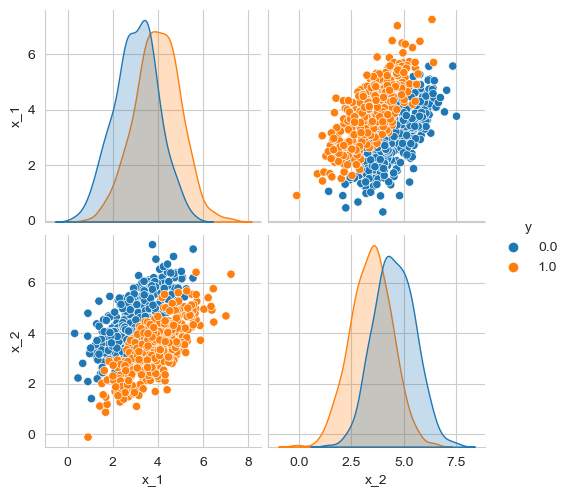

In [6]:
sns.set_style('whitegrid')
sns.pairplot(data, hue='y')
plt.show()

C:\Users\Adrij\AppData\Local\Temp\ipykernel_18028\968451210.py:3: DeprecationWarning: `np.bool` is a deprecated alias for the builtin `bool`. To silence this warning, use `bool` by itself. Doing this will not modify any behavior and is safe. If you specifically wanted the numpy scalar type, use `np.bool_` here.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  mask = np.zeros_like(data_corr, dtype=np.bool)


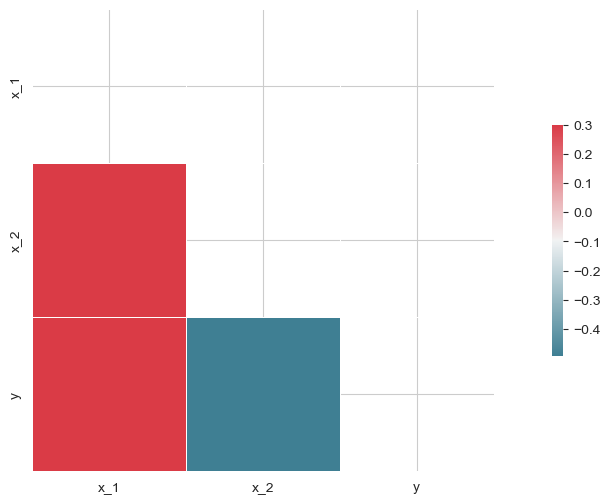

In [7]:
sns.set_style('whitegrid')
plt.figure(figsize=(15,6))
mask = np.zeros_like(data_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True
cmap = sns.diverging_palette(220, 10, as_cmap=True)
sns.heatmap(data_corr,mask=mask, cmap=cmap, vmax=.3,
square=True,
linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

* This function takes the data matrix `X` and the locations of all
centroids inside `centroids` 
* It should output a one-dimensional array `idx` (which has the same number of elements as `X`) that holds the index  of the closest centroid (a value in $\{0,...,K-1\}$, where $K$ is total number of centroids) to every training example . *(Note: The index range 0 to K-1 varies slightly fro<a name="1.1"></a>
### 1.1 Finding closest centroids

In the “cluster assignment” phase of the K-means algorithm, the
algorithm assigns every training example $x^{(i)}$ to its closest
centroid, given the current positions of centroids. 
m what is shown in the lectures (i.e. 1 to K) because Python list indices start at 0 instead of 1)*
* Specifically, for every example $x^{(i)}$ we set
$$c^{(i)} := j \quad \mathrm{that \; minimizes} \quad ||x^{(i)} - \mu_j||^2,$$
where 
 * $c^{(i)}$ is the index of the centroid that is closest to $x^{(i)}$ (corresponds to `idx[i]` in the starter code), and 
 * $\mu_j$ is the position (value) of the $j$’th centroid. (stored in `centroids` in the starter code)
 * $||x^{(i)} - \mu_j||$ is the L2-norm

In [9]:
cols = list(data.columns.values)
cols.pop(cols.index('x_1'))
data = data[cols+['x_1']]
cols = list(data.columns.values)
cols.pop(cols.index('x_2'))
data = data[cols+['x_2']]
cols = list(data.columns.values)
cols.pop(cols.index('y'))
data = data[cols+['y']]
data.head()

,x_1,x_2,y
0,3.759481,7.507940,0.0
1,3.422057,4.991203,0.0
2,2.778818,4.112071,0.0
3,4.018066,5.653732,0.0
4,1.806062,4.685966,0.0


Now, we need to capture only the required feature(s) from the table into a variable of any name, say $ X $. The empty space before first semicolon indicates `all rows must be considered`. Also, <b>7:100</b> indicates <u>extract columns from index 7 to index 100</u>(Remember index starts from 0).

In [10]:
X = data.iloc[:,7:100].values
print("First five elements of X are:\n", X[:5]) 
print('The shape of X is:', X.shape)

First five elements of X are:
 []
The shape of X is: (800, 0)


However it is unable to withstand required features.
So, we will extract data from our dataset using the `train_test_split` command

In [11]:
from sklearn.model_selection import train_test_split
# Divide the training data to dependent and independent variables
X_train, x_test, y_train, Y_test=train_test_split(data[['x_1','x_2']],data['y'],test_size=0.01)
X_test, x_train, y_test, Y_train=train_test_split(testdata[['x_1','x_2']],testdata['y'],test_size=0.01)

In [12]:
print("First five elements of training set of X are:\n", X_train[:5]) 
print('The shape of taining set of X is:', X_train.shape)

First five elements of training set of X are:
           x_1       x_2
687  3.987728  2.302403
677  3.386528  3.000511
181  3.102463  4.012341
60   2.541442  3.772465
523  2.964617  2.594678
The shape of taining set of X is: (792, 2)


Now, we need to find out the optimum number of clusters to be created in our plot using ‘Elbow Method’.

## Elbow Method:

It is the method of plotting the variation as a function of the number of clusters, and picking the elbow shaped point of the curve as the optimum number of clusters to be created.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environme

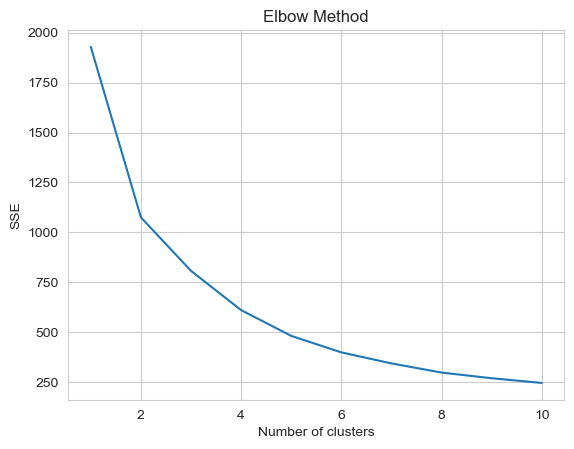

In [13]:
#elbow method
wcss = []
for i in range(1,11):
    k_means = KMeans(n_clusters=i,init='k-means++', random_state=42)
    k_means.fit(X_train)
    wcss.append(k_means.inertia_)
    
#plot elbow curve

plt.plot(np.arange(1,11),wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('SSE')
plt.show()

Now, from the elbow curve it is clear that the optimum number of clusters i.e., <u>n_clusters</u> is $2$. Then we will apply optimum k-means clustering for the data to find the cluster number of each data.

In [14]:
k_means_optimum = KMeans(n_clusters = 2, init = 'k-means++',  random_state=42)
y = k_means_optimum.fit_predict(X_train)
print(y)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


[1 1 1 1 1 1 1 0 1 1 0 1 1 0 0 1 1 1 0 1 1 1 0 1 1 1 0 0 1 0 0 1 1 0 0 1 0
 1 0 1 1 1 1 1 0 1 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 1 1 1 1 0 1 1 1 0 0 1 0 0
 0 0 1 0 0 0 1 0 0 0 0 0 0 1 0 1 1 1 1 0 0 1 1 0 0 1 1 1 0 0 1 1 1 1 0 0 1
 1 0 1 1 0 0 0 0 0 1 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1 0 0 0 0 1 0 1 0 1 0 0 0
 1 0 1 1 0 1 0 0 1 0 1 0 1 0 0 1 0 1 0 1 0 1 1 0 0 1 0 1 0 0 0 0 0 1 0 1 1
 1 1 1 1 0 0 0 1 0 0 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 1 1 0 1 1 0 1 0 1 0 1
 1 1 0 1 0 1 0 1 0 1 1 0 1 0 0 1 1 0 1 1 0 0 1 0 1 0 1 0 1 0 0 0 0 0 0 0 0
 0 1 0 0 1 0 1 1 0 1 0 1 0 0 1 0 0 1 1 0 1 1 1 0 0 1 1 1 1 0 1 1 1 1 0 1 1
 1 0 0 0 0 0 0 0 0 1 1 0 0 1 1 1 0 1 1 1 1 0 0 0 1 0 0 1 1 1 1 0 1 0 1 1 0
 1 1 1 0 0 1 1 1 1 1 0 0 0 0 0 1 0 0 0 1 0 1 0 0 1 1 0 0 1 0 0 1 0 1 1 0 0
 0 0 0 1 1 1 1 0 0 0 0 0 1 1 0 0 0 1 0 1 0 0 0 1 1 0 0 0 0 1 1 1 1 1 0 1 0
 1 0 0 0 0 1 0 0 0 0 0 0 1 1 0 0 0 1 1 0 0 1 0 1 0 0 1 1 0 0 1 1 0 0 0 1 0
 1 0 1 1 0 1 1 0 1 0 0 0 0 1 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 0 0 1 0 1 1 1 1
 1 1 0 0 0 0 1 1 0 0 0 0 

Now, we will <u>add an extra column</u> at the end named `cluster` to denote each cluster the data belongs to.

Also, We remove <u>last 8 columns</u> of the table below, because, while using `train_test_split()` we have kept the shape of $X train$ as `(792,2)` whereas the shape of $y$ is `(800,1)` which will give an <b>Error</b>

In [15]:
# Dropping last 8 rows using drop
data.drop(data.tail(8).index,
        inplace = True)

In [16]:
data['cluster'] = y  
# the above step adds extra column indicating the cluster number for each country

In [17]:
data.head()

,x_1,x_2,y,cluster
0,3.759481,7.507940,0.0,1
1,3.422057,4.991203,0.0,1
2,2.778818,4.112071,0.0,1
3,4.018066,5.653732,0.0,1
4,1.806062,4.685966,0.0,1


You can now separate the data table into two. One containing data with `cluster 0`(first cluster) and other containing data with `cluster 1`(second cluster). We name it as `data1` and `data2` respectively.

In [18]:
data1 = data[data.cluster==0]
data2 = data[data.cluster==1]

Since, we have obtained the required data separated into clusters, let's start plotting them. Now instead of <u>2D plot</u>, we make use of <u>3D plot</u> since we are working with 3 features here. We assign `cluster1` the color `orange` and `cluster2` the color `blue`.

Then, we will create `centroids` for clusters and assign some color say <b>indigo</b> and denote them with `Asterisks(*)`.

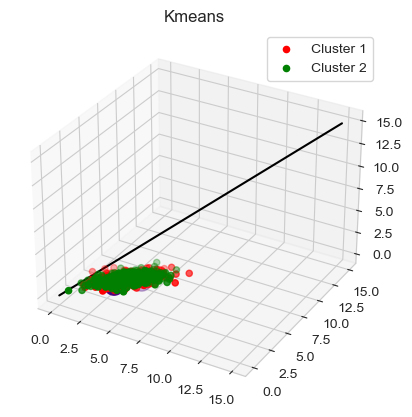

In [19]:
kplot = plt.axes(projection='3d')
xline = np.linspace(0, 15, 1000)
yline = np.linspace(0, 15, 1000)
zline = np.linspace(0, 15, 1000)
kplot.plot3D(xline, yline, zline, 'black')

# Data for three-dimensional scattered points

kplot.scatter3D(data1.x_1, data1.x_2, data1.y, c='red', label = 'Cluster 1')
kplot.scatter3D(data2.x_1,data2.x_2,data2.y,c ='green', label = 'Cluster 2')
plt.scatter(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], color = 'indigo', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()

We will now evaluate the points of centroids of Clusters for reimproving the model

In [20]:
from sklearn.datasets import make_blobs
import matplotlib.pyplot as plt

dataset = make_blobs(n_samples=792, centers = 2,n_features = 3, cluster_std = 1.6, random_state = 42)
points = dataset[0]

from sklearn.cluster import KMeans
kmeans = KMeans(n_clusters=2)
kmeans.fit(points)
clusters = kmeans.cluster_centers_
clusters

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=4.
  warnings.warn(


array([[-2.40065736,  8.96115095,  4.75832989],
       [ 2.12009469, -6.87374887, -6.8781063 ]])

Here we will use `MinMaxScaler` to evaluate and Scale down the values of columns of `x_1` and `x_2` such that we can better readjust the Model and yield Better Output.

In [21]:
from sklearn.preprocessing import MinMaxScaler
scaler= MinMaxScaler()

#transform Column (x_1)
scaler.fit(data)
print(scaler.data_max_)
data = scaler.transform(data)

[7.24274039 7.5079397  1.         1.        ]


In [22]:
#convert Numpy Array to Dataframe
data = pd.DataFrame(data, columns = ['x_1','x_2','y','cluster'])
#viewing dataset
data

,x_1,x_2,y,cluster
0,0.497521,1.000000,0.0,1.0
1,0.448846,0.669607,0.0,1.0
2,0.356055,0.554196,0.0,1.0
3,0.534824,0.756583,0.0,1.0
4,0.215730,0.629536,0.0,1.0
...,...,...,...,...
787,0.737381,0.632948,1.0,0.0
788,0.469730,0.473482,1.0,0.0
789,0.504269,0.546105,1.0,0.0
790,0.632394,0.580904,1.0,1.0


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


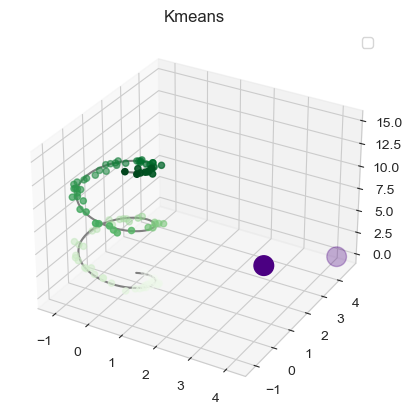

In [23]:
ax = plt.axes(projection='3d')

# Data for a three-dimensional line
zline = np.linspace(0, 15, 1000)
xline = np.sin(zline)
yline = np.cos(zline)
ax.plot3D(xline, yline, zline, 'gray')

# Data for three-dimensional scattered points
zdata = 15 * np.random.random(100)
xdata = np.sin(zdata) + 0.1 * np.random.randn(100)
ydata = np.cos(zdata) + 0.1 * np.random.randn(100)
ax.scatter3D(xdata, ydata, zdata, c=zdata, cmap='Greens')

kplot.scatter3D(data1.x_1, data1.x_2, data1.y, c='red', label = 'Cluster 1')
kplot.scatter3D(data2.x_1,data2.x_2,data2.y,c ='green', label = 'Cluster 2')
plt.scatter(k_means_optimum.cluster_centers_[:,0], k_means_optimum.cluster_centers_[:,1], color = 'indigo', s = 200)
plt.legend()
plt.title("Kmeans")
plt.show()

And that’s it. We have now successfully plotted a 3D plot for the required features. 

We will now use a metric called `Silhouette score` to evaluate the quality of clusters created in terms of how well samples are clustered with other samples that are similar to each other. Of course, the higher the score, the better the algorithm.

The process to obtain the `Silhouette score` by a given built-in python library is given below.

In [24]:
from sklearn.metrics import silhouette_score
data

,x_1,x_2,y,cluster
0,0.497521,1.000000,0.0,1.0
1,0.448846,0.669607,0.0,1.0
2,0.356055,0.554196,0.0,1.0
3,0.534824,0.756583,0.0,1.0
4,0.215730,0.629536,0.0,1.0
...,...,...,...,...
787,0.737381,0.632948,1.0,0.0
788,0.469730,0.473482,1.0,0.0
789,0.504269,0.546105,1.0,0.0
790,0.632394,0.580904,1.0,1.0


0.2416128812534678


TypeError: Input z must be 2D, not 1D

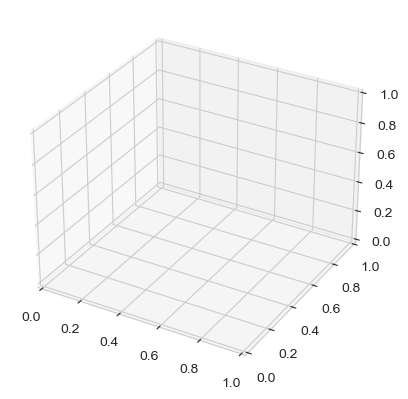

In [25]:
score = silhouette_score(X_train,y_train)
print(score)
def z(x, y):
    return np.sin(np.sqrt(x ** 2 + y ** 2))

x = np.linspace(-6, 6, 30)
y = np.linspace(-6, 6, 30)

X_train, y_train = np.meshgrid(x, y)
Z = z(X_train, y_train)



fig = plt.figure()
ax = plt.axes(projection='3d')
ax.contour3D(data.x_1, data.x_2,data.y, 792, cmap='binary')
ax.set_xlabel('x')
ax.set_ylabel('y')
ax.set_zlabel('z')

## K-Means Clustering for Hyperparameter Tuning

`K-Means clustering` is a popular unsupervised machine learning algorithm for clustering data. The algorithm works as follows to cluster data points:

  - First, we define a number of clusters, let it be K here
  - Randomly choose K data points as centroids of the clusters
  - Classify data based on Euclidean distance to either of the clusters
  - Update the centroids in each cluster by taking means of data points
  - Repeat the steps from step 3 for a set number of times (hyperparameter: max_iter)

Even though this seems pretty simple, there are a lot of ways to hypertune K-Means clustering. This includes correctly choosing the points to initialize centroids and a lot more. We will discuss one of them below, the <u>Silhouette Coefficient</u>, which gives a good idea of how many clusters to choose from.


## Implementing K-Means Clustering + SVR

We will be using the dataset for this implementation. Here our independent variables are `x_1` and `x_2`.  `y` is our target variable which we will predict on. Let us first visualize the data points to define the need for clustering.

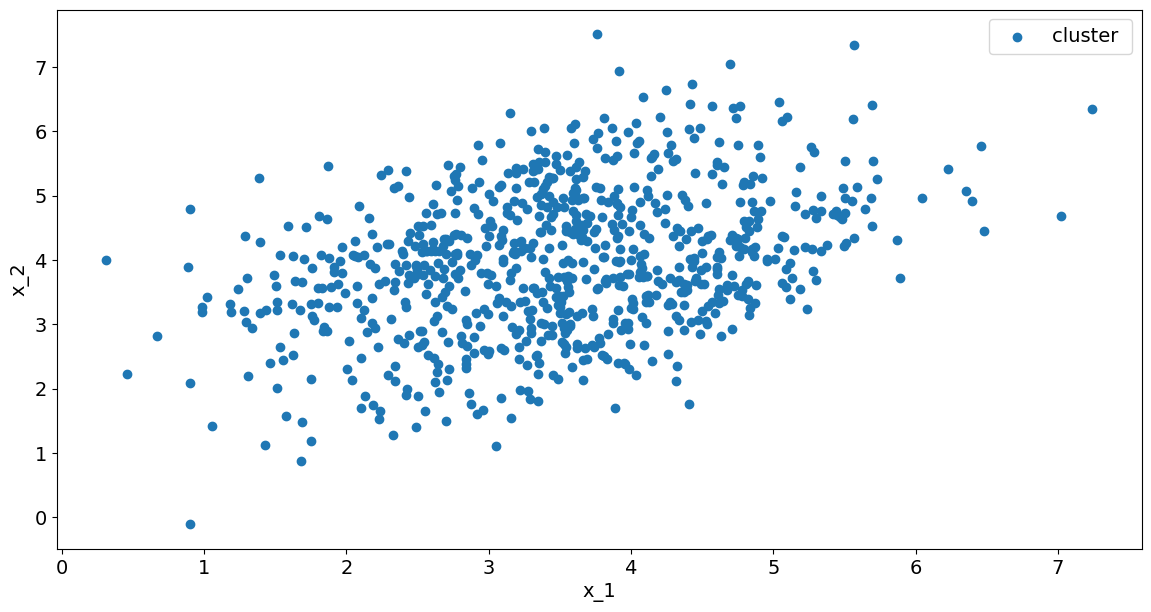

In [1]:
import pandas as pd # for data manipulation
import numpy as np # for data manipulation
import matplotlib.pyplot as plt

# Read data into a dataframe
df = pd.read_csv('C:\\Users\\Adrij\\Documents\\Data Analysis and Machine Learning\\ds2_train.csv')
testdf=pd.read_csv('C:\\Users\\Adrij\\Documents\\Data Analysis and Machine Learning\\ds2_test.csv')

# Defining Dependent and Independant variable
X = np.array(df[['x_1','x_2']])
Y = df['y'].values

# Plotting the Clusters using matplotlib
plt.rcParams['figure.figsize'] = [14, 7]
plt.rc('font', size=14)

plt.scatter(df['x_1'],df['x_2'],label="cluster ")
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()

Clearly, data points are not having a good distribution to suit a hyperplane that contains them. Let us cluster them using K-Means clustering. Before we start, we can use the Silhouette Coefficient to determine the number of clusters we need that can keep data points accurately in the selected number of clusters. Better Silhouette Coefficient or Score means better clustering. It signifies the distance between the clusters. A maximum score of 1 implying clusters are well apart from each other and also clearly distinguished, a score of 0 implying insignificant distance between the clusters, and -1 implying incorrect assigning of clusters.

Let us first evaluate Silhouette Coefficient for our data points. We will split data into train and test from here to start moving towards our final objective. Clustering will be executed over the training data.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(
C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Window

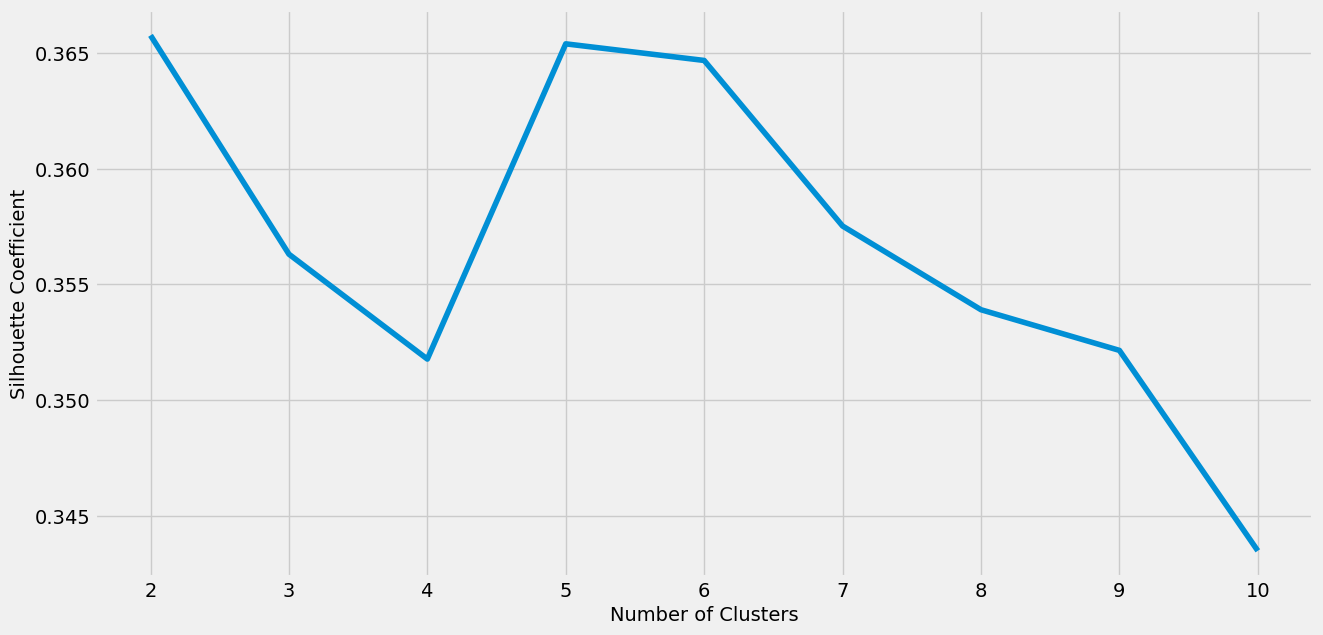

In [2]:
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import statistics
from scipy import stats

X_train, X_test, Y_train, Y_test = train_test_split(
 X, Y, test_size=0.2, random_state=42)


silhouette_coefficients = []

kmeans_kwargs= {
    "init":"random",
    "n_init":10,
    "max_iter":300,
    "random_state":42
}

for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, **kmeans_kwargs)
    kmeans.fit(X_train)
    score = silhouette_score(X_train, kmeans.labels_)
    silhouette_coefficients.append(score)
    
# Plotting graph to choose the best number of clusters
# with the most Silhouette Coefficient score

import matplotlib.pyplot as plt

plt.style.use("fivethirtyeight")
plt.plot(range(2, 11), silhouette_coefficients)
plt.xticks(range(2, 11))
plt.xlabel("Number of Clusters")
plt.ylabel("Silhouette Coefficient")
plt.show()

We can arrive at the conclusion that with 2 clusters, we can achieve better clustering. Let's go ahead and cluster the training set data.

C:\ProgramData\anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:1382: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=3.
  warnings.warn(


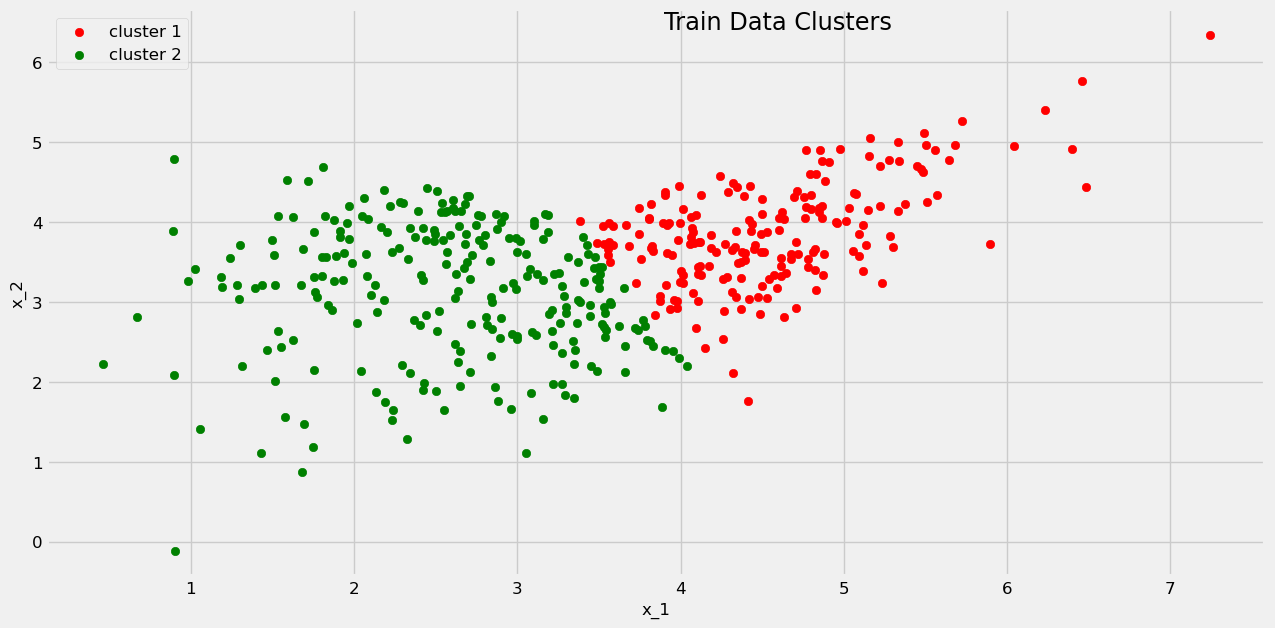

In [3]:
from sklearn.cluster import KMeans
import matplotlib.pyplot as plt
import pandas as pd # for data manipulation
import numpy as np # for data manipulation

# Instantiate the model: KMeans from sklearn
kmeans = KMeans(
    init="random",
    n_clusters=3,
    n_init=10,
    max_iter=300,
    random_state=42
)

# Fit to the training data
kmeans.fit(X_train)

train_df = pd.DataFrame(X_train,columns=['x_1','x_2'])

# Generate out clusters
train_cluster = kmeans.predict(X_train)

# Add the target and predicted clusters to our training DataFrame
train_df.insert(2,'y',Y_train) 
train_df.insert(3,'cluster',train_cluster) 
n_clusters=2
train_clusters_df = []
for i in range(n_clusters):
    train_clusters_df.append(train_df[train_df['cluster']==i])
    
colors = ['red','green','blue']
plt.rcParams['figure.figsize'] = [14, 7]
plt.rc('font', size=12)

# Plot X_train again with features labeled by cluster
for i in range(n_clusters):
  subset = []
  for count,row in enumerate(X_train):
      if(train_cluster[count]==i):
        subset.append(row)

  x = [row[0] for row in subset]
  y = [row[1] for row in subset]
  plt.scatter(x,y,c=colors[i],label="cluster "+ str(i+1))
plt.title("Train Data Clusters", x=0.6, y=0.95)
plt.xlabel("x_1")
plt.ylabel("x_2")
plt.legend()
plt.show()

## Building SVR for clusters

Now, let us go ahead and build SVR Models for each cluster. We are not focusing on the hypertuning of SVR's here. It can be done if needed by trying out various combinations of parameter values using a gridsearch.

In [4]:
import pandas as pd
import numpy as np
from sklearn.svm import SVR

n_clusters=2
cluster_svr = []
model = SVR(kernel='rbf', C=1000, epsilon=1)

for i in range(n_clusters):
    cluster_X = np.array((train_clusters_df[i])[['x_1','x_2']])
    cluster_Y = (train_clusters_df[i])['y'].values
    cluster_svr.append(model.fit(cluster_X, cluster_Y))

Let us define a function that will predict `Target Value (Y)` by predicting the cluster first, and then the value with the corresponding SVR.

In [5]:
def regression_function(arr, kmeans, cluster_svr):
    result = []
    clusters_pred = kmeans.predict(arr)
    for i,data in enumerate(arr):
        result.append(((cluster_svr[clusters_pred[i]]).predict([data]))[0])
    return result,clusters

Now that we have built our end-to-end flow for prediction and constructed the required models, we can go ahead and try this out on our test data. Let us first visualize the clusters of test data with the K means cluster we built, and then find the Y value using the corresponding SVR using the function we have written above.  

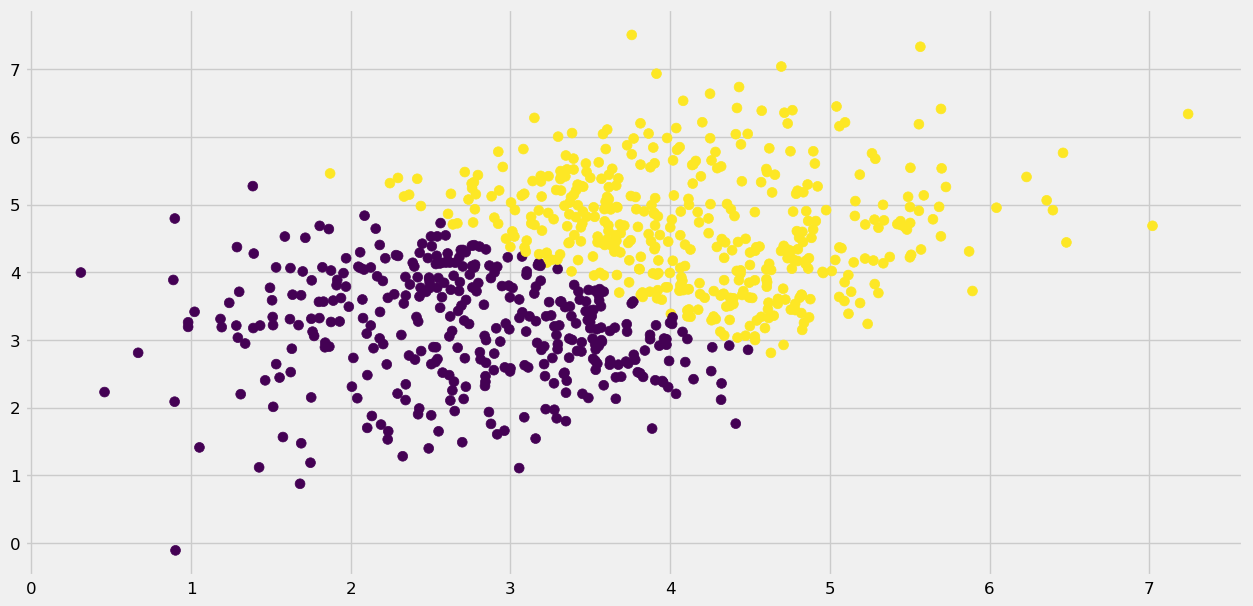

In [6]:
from sklearn.metrics import pairwise_distances_argmin

def find_clusters(X, n_clusters, rseed=2):
    # 1. Randomly choose clusters
    rng = np.random.RandomState(rseed)
    i = rng.permutation(X.shape[0])[:n_clusters]
    centers = X[i]
    
    while True:
        # 2a. Assign labels based on closest center
        labels = pairwise_distances_argmin(X, centers)
        
        # 2b. Find new centers from means of points
        new_centers = np.array([X[labels == i].mean(0)
                                for i in range(n_clusters)])
        
        # 2c. Check for convergence
        if np.all(centers == new_centers):
            break
        centers = new_centers
    
    return centers, labels

centers, labels = find_clusters(X, 2)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

### The globally optimal result may not be achieved

First, although the E–M procedure is guaranteed to improve the result in each step, there is no assurance that it will lead to the global best solution. For example, if we use a different random seed in our simple procedure, the particular starting guesses lead to poor results:

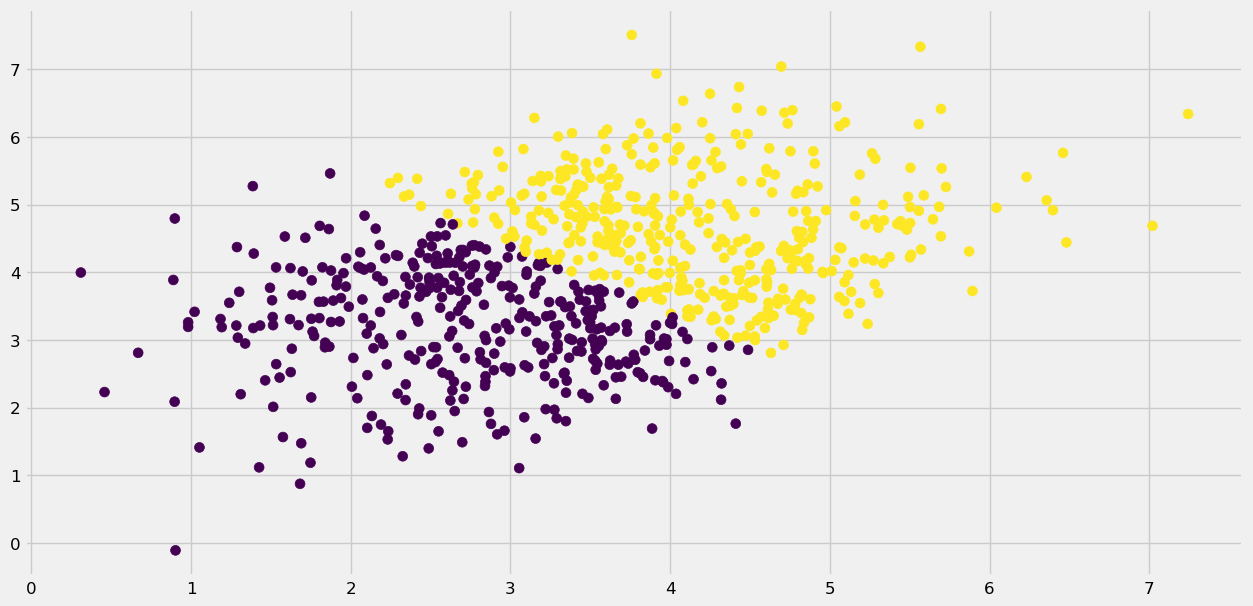

In [7]:
centers, labels = find_clusters(X, 2, rseed=0)
plt.scatter(X[:, 0], X[:, 1], c=labels,
            s=50, cmap='viridis')

Here the E–M approach has converged, but has not converged to a globally optimal configuration. For this reason, it is common for the algorithm to be run for multiple starting guesses, as indeed Scikit-Learn does by default (set by the n_init parameter, which defaults to 10).

Here, we created the object rfc of RandomForestClassifier().

## Initializing GridSearchCV() object and fitting it with hyperparameters

Here, we passed the estimator object `rfc`, `param_grid` as `forest_params`, `cv` = 10 and scoring method as `accuracy` in to GridSearchCV() as arguments.

In [11]:
import pandas as pd
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split,GridSearchCV
rfc = RandomForestClassifier()
forest_params = [{'max_depth': list(range(10, 15)), 'max_features': list(range(0,14))}]

clf = GridSearchCV(rfc, forest_params, cv = 10, scoring='accuracy')

clf.fit(X_train, Y_train)

C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py:378: FitFailedWarning: 
50 fits failed out of a total of 700.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\model_selection\_validation.py", line 686, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\ensemble\_forest.py", line 340, in fit
    self._validate_params()
  File "C:\ProgramData\anaconda3\lib\site-packages\sklearn\base.py", line 581, in _validate_params
    validate_parameter_constraints(
  File "C:\ProgramData\anaconda3\lib\site-packag

GridSearchCV(cv=10, estimator=RandomForestClassifier(),
             param_grid=[{'max_depth': [10, 11, 12, 13, 14],
                          'max_features': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11,
                                           12, 13]}],
             scoring='accuracy')

In [12]:
print(clf.best_params_)

{'max_depth': 10, 'max_features': 1}


In [13]:
print(clf.best_score_)

0.884375


Best Params and Best Score of the Random Forest Classifier

Thus, `clf.best_params_` gives the best combination of tuned hyperparameters, and `clf.best_score_` gives the average cross-validated score of our Random Forest Classifier.